In [1]:
import numpy as np
import os

from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
class NB:

    def __init__(self, lambdas, alpha):
        self.lambdas = lambdas
        self.alpha = alpha
        self.bows = {}
        self.classes = {}
        self.V = 0

    def fit(self, X_train, y_train):
        words_classes = {}
        classes = Counter()
        V = set()
        for i in range(len(X_train)):
            if y_train[i] in words_classes:
                words_classes[y_train[i]] += X_train[i]
                classes[y_train[i]] += 1
            else:
                words_classes[y_train[i]] = X_train[i].copy()
                classes[y_train[i]] += 1
            V = V.union(set(X_train[i]))
        for k, v in words_classes.items():
            words_classes[k] = Counter(v)
        self.bows = words_classes
        self.V = len(V)
        self.classes = classes


    def predict(self, X):
        y_pred = []
        y_roc = []
        for i in range(len(X)):
            probs = []
            for c in self.classes:
                prob = 0
                for word in X[i]:
                    prob += np.log((self.bows[c][word] + self.alpha) / (self.alpha * self.V + sum(self.bows[c].values())))
                probs.append(np.log(self.lambdas[c] * self.classes[c] / sum(self.classes.values())) + prob)
            index = probs.index(max(probs))
            for i, v in enumerate(self.classes):
                if i == index:
                    y_pred.append(v)
            probs_n = [0.0] * len(probs)
            for i in range(len(probs)):
                probs_n[i] = probs[i] / sum(probs)
            y_roc.append((1 - probs_n[1]))
        return y_pred, y_roc

In [7]:
def get_data(n):
    y = []
    X = []
    for dname in os.listdir('datasets/nb/'):
        c = 0
        for filename in os.listdir(f'datasets/nb/{dname}/'):
            with open(f'datasets/nb/{dname}/{filename}', encoding='utf-8', mode='r') as f:
                data = f.read()
                if 'legit' in filename:
                    y.append('l')
                else:
                    y.append('s')
                words = []
                for j in range(n):
                    msg = list(filter(str.isnumeric, data.split()))
                    words += [' '.join(msg[i: i + j + 1]) for i in range(len(msg) - j)]
                X.append(words)
    return X, y

In [4]:
def split_train_test(X, y, i):
    X_test = X[i * 109: (i + 1) * 109]
    X_train = X[: i * 109] + X[(i + 1) * 109:]
    y_test = y[i * 109: (i + 1) * 109]
    y_train = y[: i * 109] + y[(i + 1) * 109:]
    return X_train, X_test, y_train, y_test

In [5]:
def calclate_blocked_legit(y_true, y_pred):
    c = 0
    for i in range(len(y_true)):
        if y_pred[i] == 's' and y_true[i] == 'l':
            c += 1
    return c

### Обучение модели

In [8]:
X, y = get_data(1)
accs = []
for i in range(0, 10):
    X_train, X_test, y_train, y_test = split_train_test(X, y, i)
    clf = NB({'l': 1, 's': 1}, 0.01)
    clf.fit(X_train, y_train)
    y_pred, _ = clf.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
print(f'acc: {sum(accs) / len(accs)}')

acc: 0.9788990825688074


In [64]:
X, y = get_data(1)
clf = NB({'l': 1, 's': 1}, 0.01)
X_train, X_test, y_train, y_test = split_train_test(X, y, 5)
clf.fit(X_train, y_train)
y_pred, y_roc = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

IntProgress(value=0, max=109)

0.963302752293578


### Построение ROC-кривой

In [65]:
y_prob = list(zip(y_roc, y_test))
y_prob.sort()

In [66]:
labels = [obj[1] for obj in y_prob]

In [67]:
legit_n = labels.count('l')

In [68]:
spam_n = labels.count('s')

In [69]:
points_x = [0]
points_y = [0]
for l in labels:
    if l == 's':
        points_y.append(1 / spam_n + points_y[-1])
        points_x.append(points_x[-1])
    else:
        points_y.append(points_y[-1])
        points_x.append(1 / legit_n + points_x[-1])
const_x = np.linspace(0, 1, 30)
const_y = np.linspace(0, 1, 30)

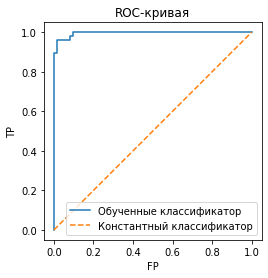

In [70]:
plt.plot(points_x, points_y, label='Обученные классификатор')
plt.plot(const_x, const_y, linestyle='--', label='Константный классификатор')
plt.title('ROC-кривая')
plt.xlabel('FP')
plt.ylabel('TP')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

### Настройка $\lambda$<sub>legit</sub>

In [9]:
X, y = get_data(1)
blocked = -1
i = 0
accs = []
X_train, X_test, y_train, y_test = split_train_test(X, y, 2)
while blocked != 0:
    clf = NB({'l': 10 ** i, 's': 1}, 0.01)
    clf.fit(X_train, y_train)
    y_pred, _ = clf.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
    blocked = calclate_blocked_legit(y_test, y_pred)
    i += 5
powers = [i * 5 for i in range(len(accs))]

In [10]:
print(clf.lambdas) #25

{'l': 10000000000000000000000000, 's': 1}


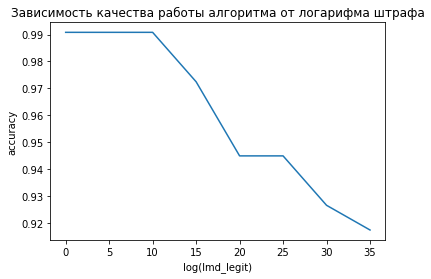

In [72]:
plt.plot(powers, accs)
plt.xlabel('log(lmd_legit)')
plt.ylabel('accuracy')
plt.title('Зависимость качества работы алгоритма от логарифма штрафа')
plt.show()